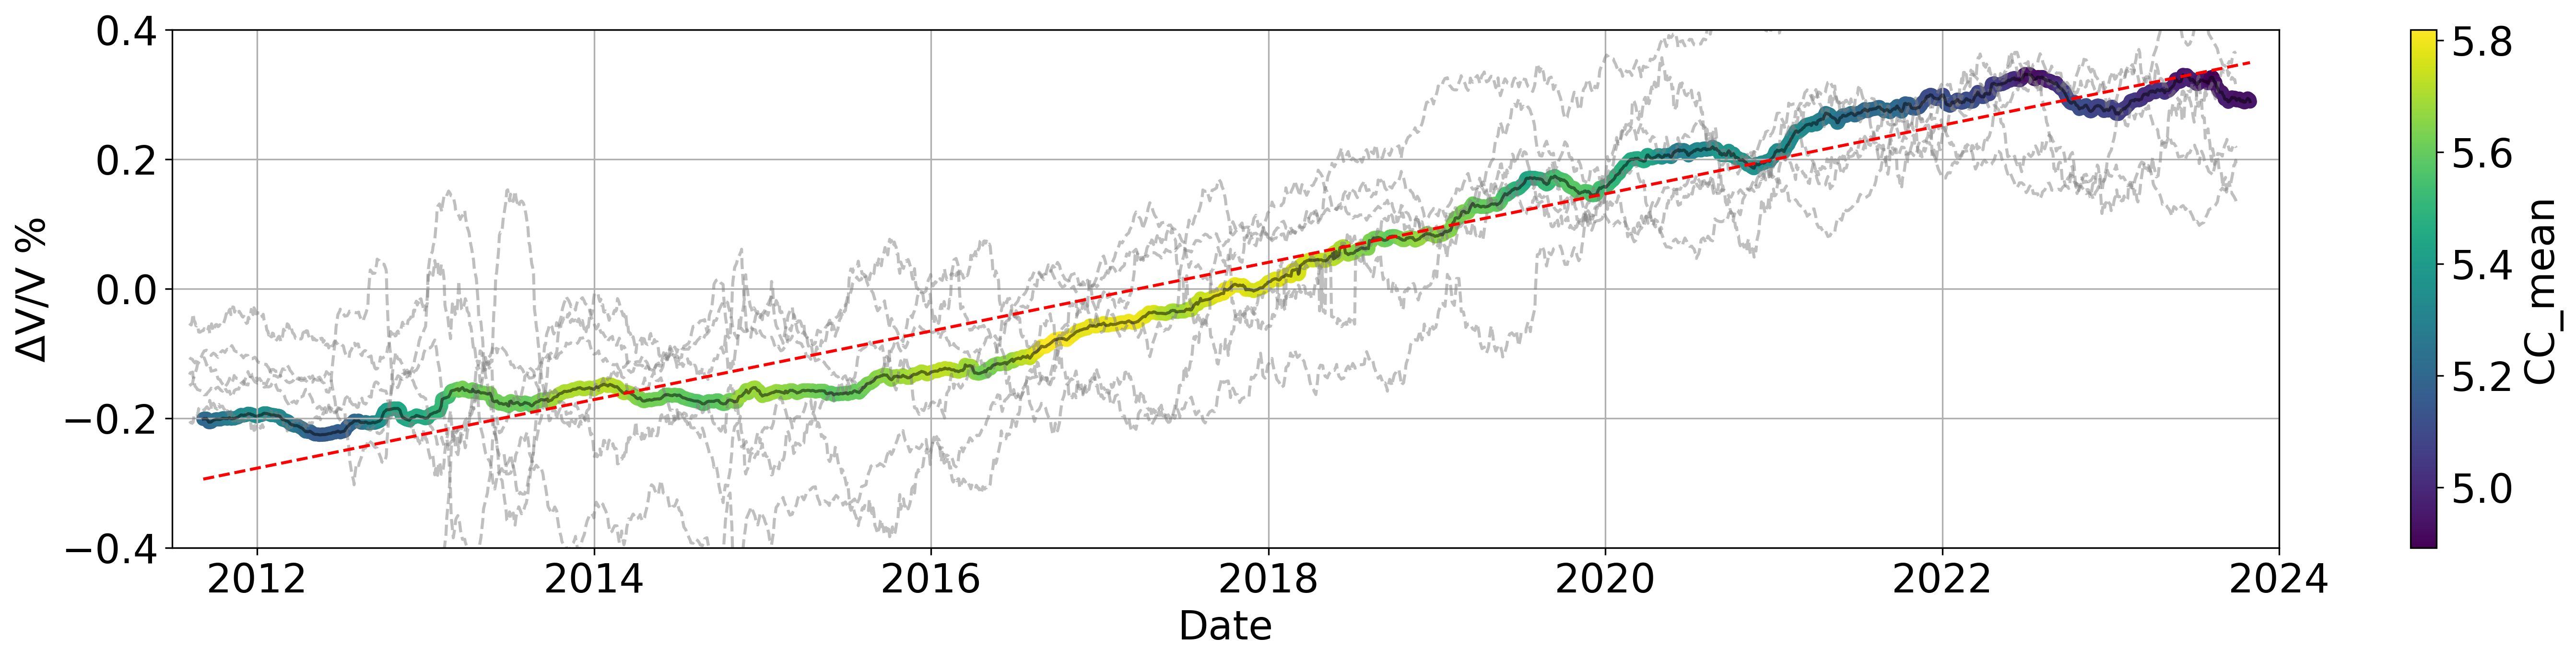

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Define the paths to your CSV files
file_paths = [
    '/home/seismic/CascadiaDVV/src/NC89 Results/89_60daystack_1p0to3p0 positiveNZ 210svd7.csv',
    '/home/seismic/CascadiaDVV/src/NC89 Results/89_60daystack_1p0to3p0 negativeNZ 102svd7.csv',
    '/home/seismic/CascadiaDVV/src/NC89 Results/89_60daystack_1p0to3p0 positiveNE 210svd7.csv',
    '/home/seismic/CascadiaDVV/src/NC89 Results/89_60daystack_1p0to3p0 negativeNE 102svd7.csv',
    '/home/seismic/CascadiaDVV/src/NC89 Results/89_60daystack_1p0to3p0 positiveZE 210svd7.csv',
    '/home/seismic/CascadiaDVV/src/NC89 Results/89_60daystack_1p0to3p0 negativeZE 102svd7.csv',
]

# Predefined array with multipliers (-1 or +1)
multipliers = [1, 1, 1, 1, 1, 1]

dataframes = []
for path, multiplier in zip(file_paths, multipliers):
    df = pd.read_csv(path)
    df['DVT'] *= multiplier  # Apply the multiplier to the DVT column
    dataframes.append(df)

# Parse timestamps and set them as the index
for df in dataframes:
    df['T'] = pd.to_datetime(df['T'])
    df.set_index('T', inplace=True)

# Create a unified time index from the union of all timestamps in the dataframes
unified_index = pd.to_datetime(sorted(set.union(*(set(df.index) for df in dataframes))))

# Interpolate data for each dataframe to match the unified index
interpolated_dfs = [df.reindex(unified_index).interpolate() for df in dataframes]

# Define the date range to exclude
exclude_ranges = [("2023-10-01", "2024-01-30"), ("2010-01-10", "2011-08-05")]
for start, end in exclude_ranges:
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    for i in range(len(interpolated_dfs)):
        interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)

# Calculate CC_mean using squared correlation coefficients for each time point
CC_mean = sum(df['CCT']**2 for df in interpolated_dfs)

# Calculate weighted Δu/u using squared CCT and DVT
weighted_dvv = sum(df['CCT']**2 * df['DVT'] for df in interpolated_dfs) / CC_mean

# Normalize CC_mean for coloring
norm = mcolors.Normalize(vmin=CC_mean.min(), vmax=CC_mean.max())
cmap = cm.viridis  # Can choose any available colormap

# Create a DataFrame for the weighted Δv/v time series
weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])
weighted_dvv_df.index = weighted_dvv_df.index + pd.DateOffset(days=30)

# Plotting the weighted Δv/v time series with color-coded CC_mean
plt.figure(figsize=(20, 5), dpi=300)

# Plot each individual dataframe on the same graph with black dashed lines
for path, df in zip(file_paths, interpolated_dfs):
    plt.plot(df.index, df['DVT'], color='grey', alpha=0.5, linestyle='--', label=f'DVT - {path.split("/")[-1]}')

# Scatter plot for individual markers with color coding
sc = plt.scatter(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], c=CC_mean, cmap=cmap, norm=norm, label='Weighted Δv/v')
# Line plot to connect markers
plt.plot(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], 'k-', alpha=0.5)  # Adjust alpha for line transparency
plt.colorbar(sc, label='CC_mean')


# Adding a trend line
cleaned_df = weighted_dvv_df.dropna(subset=['Weighted Δv/v'])
index_as_int = cleaned_df.index.astype(np.int64)
z = np.polyfit(index_as_int, cleaned_df['Weighted Δv/v'], 1)
p = np.poly1d(z)
plt.plot(weighted_dvv_df.index, p(weighted_dvv_df.index.astype(np.int64)), "r--", label='Trend Line')

plt.xlabel('Date')
plt.ylim([-0.4, 0.4])
plt.ylabel('ΔV/V %')
plt.grid(True)
plt.xlim([pd.to_datetime("2011-07-01"), pd.to_datetime("2024-01-01")])
#plt.clim([5.3,5.8])
plt.rcParams.update({'font.size': 20})
plt.tight_layout()
plt.show()


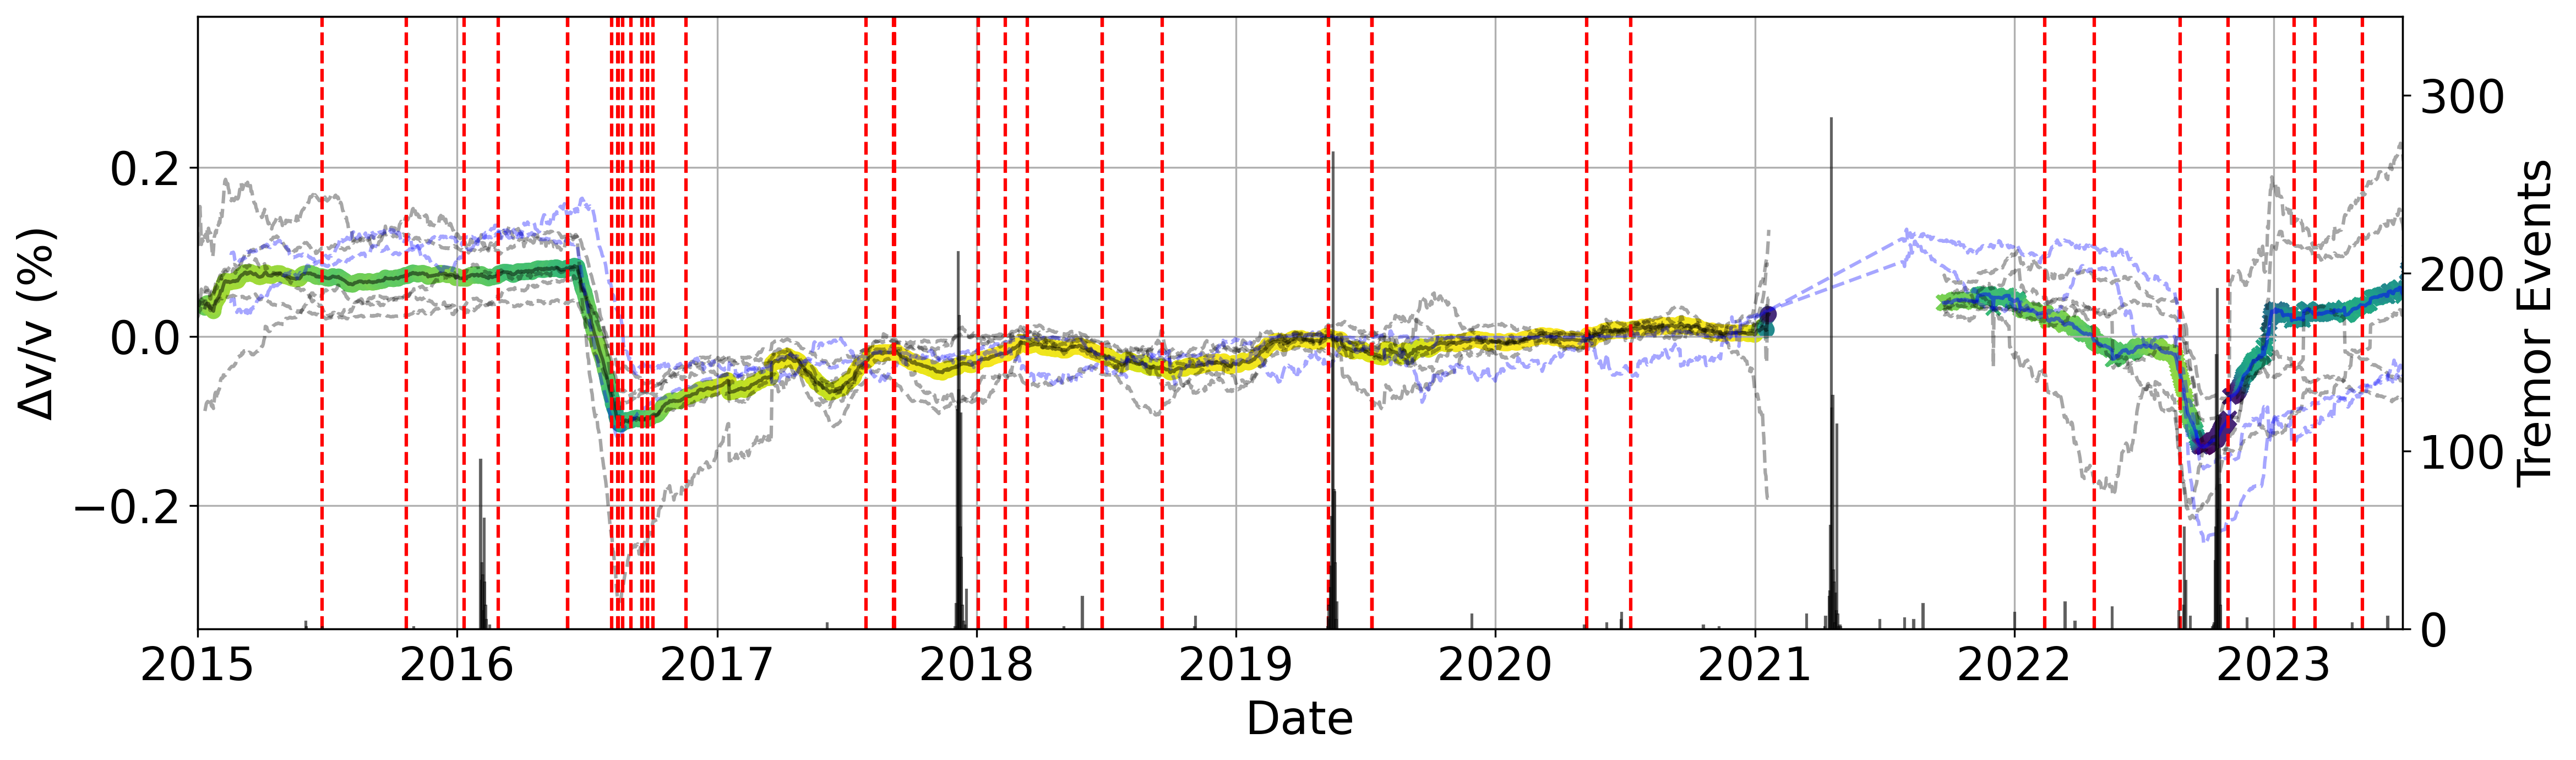

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from datetime import datetime
import matplotlib as mpl
# 1) SHALLOW TREMOR DATES
#    (Same list as before, if not already defined in your code)
Tdates = [
    '2015-06-24 22:25:29.343674','2015-10-21 07:10:22.988772','2016-01-10 21:12:28.836671',
    '2016-02-27 12:03:06.102124','2016-06-04 14:36:16.085195','2016-06-04 14:37:36.094455',
    '2016-08-05 16:32:06.889686','2016-08-14 00:35:30.246556','2016-08-14 14:38:36.101401',
    '2016-08-20 22:07:09.216344','2016-09-01 15:43:16.550527','2016-09-17 02:04:20.863526',
    '2016-09-17 02:08:10.890149','2016-09-24 18:19:27.635143','2016-09-25 03:22:01.402940',
    '2016-09-25 03:24:51.422618','2016-10-02 12:07:35.052668','2016-11-18 05:22:02.236370',
    '2017-07-29 04:03:41.692326','2017-09-06 10:28:44.366246','2017-09-06 13:01:05.424239',
    '2017-09-06 13:13:25.509897','2017-09-06 13:15:45.526103','2017-09-06 13:19:15.550411',
    '2017-09-06 13:48:05.750666','2017-09-06 13:55:55.805070','2017-09-06 13:58:15.821276',
    '2017-09-06 14:06:35.879153','2017-09-06 14:10:55.909249','2017-09-06 14:31:06.049311',
    '2017-09-06 14:47:16.161593','2017-09-06 15:14:26.350272','2017-09-06 15:32:06.472971',
    '2017-09-06 16:52:17.029749','2017-09-06 17:02:57.103831','2017-09-06 17:04:37.115407',
    '2017-09-06 17:06:47.130455','2017-09-06 17:37:27.343443','2018-01-03 15:22:06.403519',
    '2018-02-10 14:43:16.133812','2018-03-13 15:48:13.211856','2018-06-26 12:51:25.357102',
    '2018-06-26 13:01:05.424239','2018-09-19 07:27:03.104526','2019-05-11 05:18:53.169843',
    '2019-07-11 03:20:01.777251','2019-07-11 03:32:31.888329','2019-07-11 03:46:02.008294',
    '2020-05-08 09:41:54.040977','2020-07-09 09:30:43.963422','2022-02-12 03:54:41.629818',
    '2022-04-22 23:23:09.744183','2022-08-21 18:37:17.759000','2022-10-28 00:42:20.294016',
    '2023-01-29 16:30:26.878111','2023-02-27 13:00:45.421924','2023-05-05 06:52:22.863757'
]
datetime_objects = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S.%f') for date in Tdates]

# 2) READ THE TREMO(R) EVENT COUNTS  # NEW
#    Make sure the CSV has a date/time index and a column named "Number of Events".
#    Adjust file name or column name to match your actual data.
tremor_counts_file = 'Data/filtered_events_per_day_lat_44.csv'
tremor_df = pd.read_csv(tremor_counts_file, index_col=0, parse_dates=True)

# Define your existing file paths
file_paths_1 = [
    'Data/B1_60daystack_3p0to5p0 negativeZE 102svd7x.csv',
    'Data/B1_60daystack_3p0to5p0 positiveZE 210svd7x.csv',
    'Data/B1_60daystack_3p0to5p0 negativeZN 102svd7x.csv',
    'Data/B1_60daystack_3p0to5p0 positiveZN 210svd7x.csv',
    'Data/B1_60daystack_3p0to5p0 positiveNE 210svd7x.csv',
]
file_paths_2 = [
    'Data/HYSB1_addonNE_negative.csv',
    'Data/HYSB1_addonZE_positive.csv',
    'Data/HYSB1_addonZN_negative.csv',
    'Data/HYSB1_addonZN_positive.csv',
    'Data/HYSB1_addonNE_positive.csv',
]
file_paths_3 = [
    'Data/HYSB1_NE35n1_10.csv',
    'Data/HYSB1_ZE35p1_10.csv'
]
file_paths_4 = [
    'Data/B1_60daystack_3p0to5p0 negativeNE 102svd7x.csv',
]

# Predefined multipliers
multipliers_1 = [1, 1, 1, 1, 1, -1]
multipliers_2 = [1, 1, 1, 1, 1]
multipliers_3 = [1, 1]
multipliers_4 = [-1]

mpl.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20
})
def process_files(file_paths, multipliers):
    dataframes = []
    for path, multiplier in zip(file_paths, multipliers):
        df = pd.read_csv(path)
        df['DVT'] *= multiplier
        # Convert T to datetime and set as index
        df['T'] = pd.to_datetime(df['T'])
        df.set_index('T', inplace=True)
        dataframes.append(df)

    # Create a unified time index
    unified_index = pd.to_datetime(sorted(set.union(*(set(df.index) for df in dataframes))))

    # Interpolate
    interpolated_dfs = [df.reindex(unified_index).interpolate() for df in dataframes]

    # Calculate CC_mean & Weighted dvv
    CC_mean = sum(df['CCT']**2 for df in interpolated_dfs)
    weighted_dvv = sum(df['CCT']**2 * df['DVT'] for df in interpolated_dfs) / CC_mean

    weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])
    
    # SHIFT final times by +30 days if needed
    weighted_dvv_df.index = weighted_dvv_df.index + pd.DateOffset(days=30)

    return interpolated_dfs, weighted_dvv_df, CC_mean

# Process
interpolated_dfs_1, weighted_dvv_df_1, CC_mean_1 = process_files(file_paths_1, multipliers_1)
interpolated_dfs_2, weighted_dvv_df_2, CC_mean_2 = process_files(file_paths_2, multipliers_2)
interpolated_dfs_3, _, _ = process_files(file_paths_3, multipliers_3)

# Combine CC_mean for colorbar
combined_CC_mean = pd.concat([CC_mean_1, CC_mean_2])
norm = mcolors.Normalize(vmin=combined_CC_mean.min(), vmax=combined_CC_mean.max())
cmap = cm.viridis

# ---------------------------
# Plotting
# ---------------------------
# NEW: Create fig, ax
fig, ax = plt.subplots(figsize=(16, 5), dpi=300)

# Step 1: Plot each individual DVT time series in black without applying CC
for df in interpolated_dfs_1:
    df.index = df.index + pd.DateOffset(days=30)  # same shift
    ax.plot(df.index, df['DVT'], color='black', alpha=0.35, linestyle='--')
for df in interpolated_dfs_2:
    df.index = df.index + pd.DateOffset(days=30)
    ax.plot(df.index, df['DVT'], color='black', alpha=0.35, linestyle='--')

# Step 2: Weighted Δv/v (Set 1) w/ color-coded CC_mean
sc1 = ax.scatter(
    weighted_dvv_df_1.index,
    weighted_dvv_df_1['Weighted Δv/v'],
    c=CC_mean_1, cmap=cmap, norm=norm
)
ax.plot(
    weighted_dvv_df_1.index,
    weighted_dvv_df_1['Weighted Δv/v'],
    'k-', alpha=0.5
)

# Step 3: Weighted Δv/v (Set 2) w/ color-coded CC_mean
sc2 = ax.scatter(
    weighted_dvv_df_2.index,
    weighted_dvv_df_2['Weighted Δv/v'],
    c=CC_mean_2, cmap=cmap, norm=norm, marker='x'
)
ax.plot(
    weighted_dvv_df_2.index,
    weighted_dvv_df_2['Weighted Δv/v'],
    'b-', alpha=0.5
)

# Step 4: Individual Δv/v from (Set 3) in blue
for i, df in enumerate(interpolated_dfs_3):
    df.index = df.index + pd.DateOffset(days=30)
    if i == 0:
        df['DVT'] = df['DVT'] / 5  # Adjust if needed for clarity
    ax.plot(df.index, df['DVT'], color='blue', alpha=0.35, linestyle='--')

# (a) Colorbar
#cbar = plt.colorbar(sc2, ax=ax, label='CC_mean')

# (b) Plot shallow tremor dates as vertical lines
for dt in datetime_objects:
    ax.axvline(x=dt, color='red', linestyle='--')

# (c) NEW: Add a secondary axis for the tremor event counts
ax2 = ax.twinx()

# Shift the tremor events if needed to match your +30 day offset
# (Uncomment below if you want them aligned to the shifted data)
# tremor_df.index = tremor_df.index + pd.DateOffset(days=30)

ax2.bar(
    tremor_df.index,              # x-values (dates)
    tremor_df['Number of Events'],# height
    width=1.0,                    # bar width in days
    color='lightgray', 
    edgecolor='black', 
    alpha=0.6,
    label='Tremor Event Count'
)
ax2.set_ylabel('Tremor Events')
ax2.set_ylim([0, tremor_df['Number of Events'].max() * 1.2])  # some margin

# (d) Labels, etc.
ax.set_xlabel('Date')
ax.set_ylabel('Δv/v (%)')
ax.tick_params(axis='both')
ax2.tick_params(axis='y')
start_date = pd.to_datetime("2015-01-01")
end_date = pd.to_datetime("2023-07-01")
ax.set_xlim([start_date, end_date])
plt.rcParams.update({'font.size': 20})
ax.grid(True)
plt.tight_layout()
plt.show()
